In [43]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import copy
from datetime import datetime
from scipy import stats
import math
import time

In [44]:
# Open API 통해서 covid-19 현황 데이터 크롤링하기

certkey = "v0O4UCMVcwE7H9oze42M5gF%2B%2FzTzT%2FhKotohAcuAl%2BoUAPdQ3eq%2Fj9H2WbJsoe91i8%2F%2BvvLoRR7N7rFR172ebw%3D%3D"
url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson?"\
    + "ServiceKey=" + certkey \
    + "&pageNo=" + ""\
    + "&numOfRows=" + ""\
    + "&startCreateDt=" + ""\
    + "&endCreateDt=" + ""

xml = requests.get(url).text
print(xml)

<?xml version="1.0" encoding="UTF-8" standalone="yes"?><response><header><resultCode>00</resultCode><resultMsg>NORMAL SERVICE.</resultMsg></header><body><items><item><accDefRate>1.3251897470</accDefRate><accExamCnt>3441220</accExamCnt><accExamCompCnt>3347747</accExamCompCnt><careCnt>11205</careCnt><clearCnt>32559</clearCnt><createDt>2020-12-15 09:34:38.398</createDt><deathCnt>600</deathCnt><decideCnt>44364</decideCnt><examCnt>93473</examCnt><resutlNegCnt>3303383</resutlNegCnt><seq>354</seq><stateDt>20201215</stateDt><stateTime>00:00</stateTime><updateDt>null</updateDt></item><item><accDefRate>1.3145929369</accDefRate><accExamCnt>3397039</accExamCnt><accExamCompCnt>3307792</accExamCompCnt><careCnt>10795</careCnt><clearCnt>32102</clearCnt><createDt>2020-12-14 09:38:10.035</createDt><deathCnt>587</deathCnt><decideCnt>43484</decideCnt><examCnt>89247</examCnt><resutlNegCnt>3264308</resutlNegCnt><seq>353</seq><stateDt>20201214</stateDt><stateTime>00:00</stateTime><updateDt>null</updateDt></i

In [45]:
bs = BeautifulSoup(xml)
items = bs.select("item")
accTestNum = []
date = []
decideNum = []
for item in items:
    decideNum.append(int(item.select_one("decidecnt").text))
    date.append(item.select_one("statedt").text + " " +item.select_one("statetime").text)
    if item.select_one("accExamCompCnt") == None:
        accTestNum.append(np.nan)
    else:
        accTestNum.append(int(item.select_one("accExamCompCnt").text))

In [46]:
# Dataframe 생성
d = {"dateTime": date, "decideNum": decideNum, "testNum" : accTestNum}
coronadata = pd.DataFrame(d)
coronadata = coronadata.drop_duplicates(subset = ["dateTime"], keep = "last", inplace = False)
coronadata = coronadata.reset_index(drop = True)

# 오타로 인한 잘못된 정보 수정 (kaggle의 datartist 데이터와 비교/대조)
badindex = coronadata.index[coronadata["dateTime"] == "20200425 00:00"][0]
coronadata.at[badindex, "decideNum"] = 10718

indexa = coronadata.index[coronadata["dateTime"] == "20201208 00:00"][0]
indexb = coronadata.index[coronadata["dateTime"] == "20201209 00:00"][0]
temp = coronadata.iloc[indexb].copy()

coronadata.iloc[indexb] = coronadata.iloc[indexa]
coronadata.iloc[indexa] = temp

print(coronadata.head(15))

newdecideNum = []
dN = copy.deepcopy(list(coronadata["decideNum"]))
dN.append(0)
for i in range(len(dN)-1):
    newdecideNum.append(dN[i]-dN[i+1])
    
newtestNum = []
tN = copy.deepcopy(list(coronadata["testNum"]))
tN.append(0)
for i in range(len(tN)-1):
    newtestNum.append(tN[i]-tN[i+1])
    
coronadata["newDecideNum"] = newdecideNum
coronadata["newCompTestNum"] = newtestNum

# dateTime 변수를 datetime 객체로 만들기
dT = []
for k in range(len(coronadata["dateTime"])):
    dT.append(datetime.strptime(coronadata["dateTime"][k], "%Y%m%d %H:%M"))

coronadata["dateTime"] = dT
print(coronadata[1:15])

coronadata.to_csv("coronadata.csv")

          dateTime  decideNum    testNum
0   20201215 00:00      44364  3347747.0
1   20201214 00:00      43484  3307792.0
2   20201213 00:00      42766  3284466.0
3   20201212 00:00      41736  3263122.0
4   20201211 00:00      40786  3233525.0
5   20201210 00:00      40098  3205183.0
6   20201209 00:00      39432  3178156.0
7   20201208 00:00      38746  3150043.0
8   20201207 00:00      38161  3141366.0
9   20201206 00:00      37546  3127151.0
10  20201205 00:00      36915  3114229.0
11  20201204 00:00      36332  3093393.0
12  20201203 00:00      35703  3066098.0
13  20201202 00:00      35163  3041816.0
14  20201201 00:00      34652  3019105.0
     dateTime  decideNum    testNum  newDecideNum  newCompTestNum
1  2020-12-14      43484  3307792.0           718         23326.0
2  2020-12-13      42766  3284466.0          1030         21344.0
3  2020-12-12      41736  3263122.0           950         29597.0
4  2020-12-11      40786  3233525.0           688         28342.0
5  2020-12-10 

In [58]:
# 일일 양성률 계산 (양성률 = 일일 신규확진자수/일일 검사수)

coronadata["posRate"] = coronadata["newDecideNum"]/coronadata["newCompTestNum"] * 100

# 2020년 3월 1일 이전에는 검사자수 데이터 집계가 되어 있지 않으므로, 3월 2일부터 현재까지의 데이터만을 subset하여 분석
threshold = coronadata.index[coronadata["dateTime"]=="20200302 00:00"][0]
print(threshold)
recentdata = coronadata[:threshold+1]

recentdata = recentdata.iloc[7:,]
recentdata.reset_index(inplace = True)
print(recentdata)

288
     index   dateTime  decideNum    testNum  newDecideNum  newCompTestNum  \
0        7 2020-12-08      38746  3150043.0           585          8677.0   
1        8 2020-12-07      38161  3141366.0           615         14215.0   
2        9 2020-12-06      37546  3127151.0           631         12922.0   
3       10 2020-12-05      36915  3114229.0           583         20836.0   
4       11 2020-12-04      36332  3093393.0           629         27295.0   
..     ...        ...        ...        ...           ...             ...   
277    284 2020-03-06       6284   142908.0           518         18177.0   
278    285 2020-03-05       5766   124731.0           438         16438.0   
279    286 2020-03-04       5328   108293.0           516         17997.0   
280    287 2020-03-03       4812    90296.0           600         14504.0   
281    288 2020-03-02       4212    75792.0           476             NaN   

      posRate  
0    6.741962  
1    4.326416  
2    4.883145  
3    2.

In [59]:
# Shewhart's Control Chart 그리기
# n = 1, m = len(recentdata)인 moving range chart

recentdata["posRate"] = [math.log(x) for x in recentdata["posRate"]]
                        
# Moving Range 구하기
m = len(recentdata)
MR = []
for k in range(m-1):
    MR.append(abs(recentdata.loc[k, "posRate"] - recentdata.loc[k+1, "posRate"]))
    
date = recentdata["dateTime"]
data = pd.DataFrame({"date": date[:-1], "MR" : MR, "posRate" : recentdata["posRate"][0:m-1]})
data.set_index("date", inplace = True)

data = data[::-1]
print(data.head(10))

# MR statistic을 이용한 x bar 추정
# Phase 1: 초기 100일로 잡아 이 기간에 대한 control limit 설정
xbar = np.nanmean(data.tail(100)["posRate"])
MR_bar = np.nanmean(data.tail(100)["MR"])
d2_n2 = 1.128
d3_n2 = 0.853
L = 3 # 3-sigma rule 사용

UCL_xbar = xbar + L * (MR_bar/d2_n2)
CL_xbar = xbar
LCL_xbar = xbar - L * (MR_bar/d2_n2)

# MR statistic을 이용한 sigma 추정
UCL_MR = MR_bar + L*(d3_n2/d2_n2)*MR_bar
CL_MR = MR_bar
LCL_MR = max(MR_bar - L*(d3_n2/d2_n2)*MR_bar, 0)

phase1 = data.index [99] # Phase 1의 마지막날 : 2020년 6월 10일
day1 = data.index[64] # 2020-05-06
day1end = data.index[113] # 2020-06-24
day2 = data.index[180] # 2020-08-30
day2end = data.index[208] # 2020-09-27

                  MR   posRate
date                          
2020-03-03       NaN  1.419920
2020-03-04  0.366603  1.053317
2020-03-05  0.073279  0.980038
2020-03-06  0.067195  1.047233
2020-03-07  0.079025  1.126258
2020-03-08  0.118215  1.244473
2020-03-09  0.338013  0.906460
2020-03-10  0.862133  0.044327
2020-03-11  0.643627  0.687954
2020-03-12  0.850789 -0.162835


In [60]:
# MR 이용하여 xbar CL 구하는 함수 정의

def make_mr(ddd) :
    m = len(ddd)
    MR = []
    for k in range(m-1):
        MR.append(abs(ddd.loc[k, "posRate"] - ddd.loc[k+1, "posRate"]))
    dt = ddd["dateTime"]
    dfdf = pd.DataFrame({"date": dt[:-1], "MR" : MR, "posRate" : ddd["posRate"][0:m-1]})
    dfdf.set_index("date", inplace = True)
    dfdf = dfdf[::-1]
    return dfdf

def get_bar(dfdf, day):
    phase1index = dfdf.index.get_loc(day)
    xbar = np.nanmean(dfdf[0:phase1index+1]["posRate"])
    MR_bar = np.nanmean(dfdf[0:phase1index+1]["MR"])
    return [xbar, MR_bar]

def find_cl(dfdf, day) :
    xbar = get_bar(dfdf, day)[0]
    MR_bar = get_bar(dfdf, day)[1]
    d2_n2 = 1.128
    d3_n2 = 0.853
    L = 3
    UCL_xbar = xbar + L * (MR_bar/d2_n2)
    CL_xbar = xbar
    LCL_xbar = xbar - L * (MR_bar/d2_n2)
    return [UCL_xbar, CL_xbar, LCL_xbar]

mrdata = make_mr(recentdata)
phase1data = mrdata[0:100]
[UCL0, CL0, LCL0] = find_cl(phase1data, phase1)
print(find_cl(make_mr(recentdata), phase1))

[0.30745988318134987, -0.8066480348122037, -1.9207559528057572]


In [33]:
# 사회적 거리두기 단계 변화

socialDistDate = ["2020-05-06", "2020-06-24", "2020-08-30", "2020-09-27", "2020-10-12", "2020-11-22"]
socialDistExp = ["생활 속 거리 두기", "단계별 사회적 거리 두기", "수도권 2.5단계", "2단계", "1단계", "수도권 2단계"]

sDD = []
for k in range(len(socialDistDate)):
    sDD.append(datetime.strptime(socialDistDate[k], "%Y-%m-%d"))

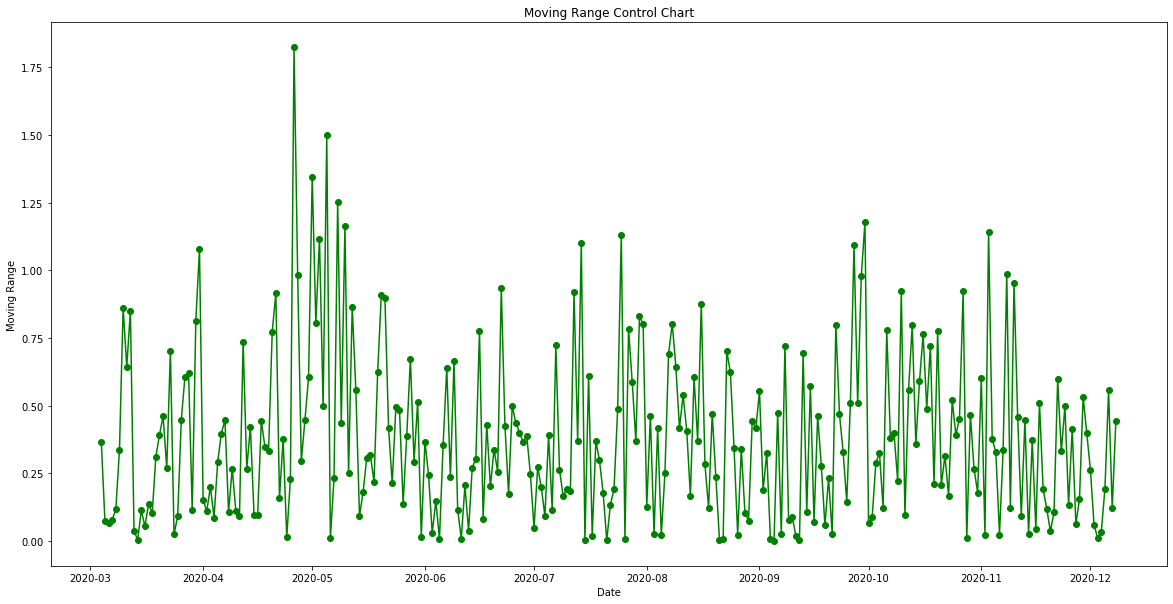

In [34]:
# Control Chart 그리기

# MR Control Chart
plt.figure(figsize=(20,10))
idx = list(data.index.values)
plt.plot("MR", data = data, color = "green", marker = "o")
plt.title("Moving Range Control Chart")
plt.xlabel("Date")
plt.ylabel("Moving Range")
plt.savefig("Shewhart moving range.png")
plt.show()


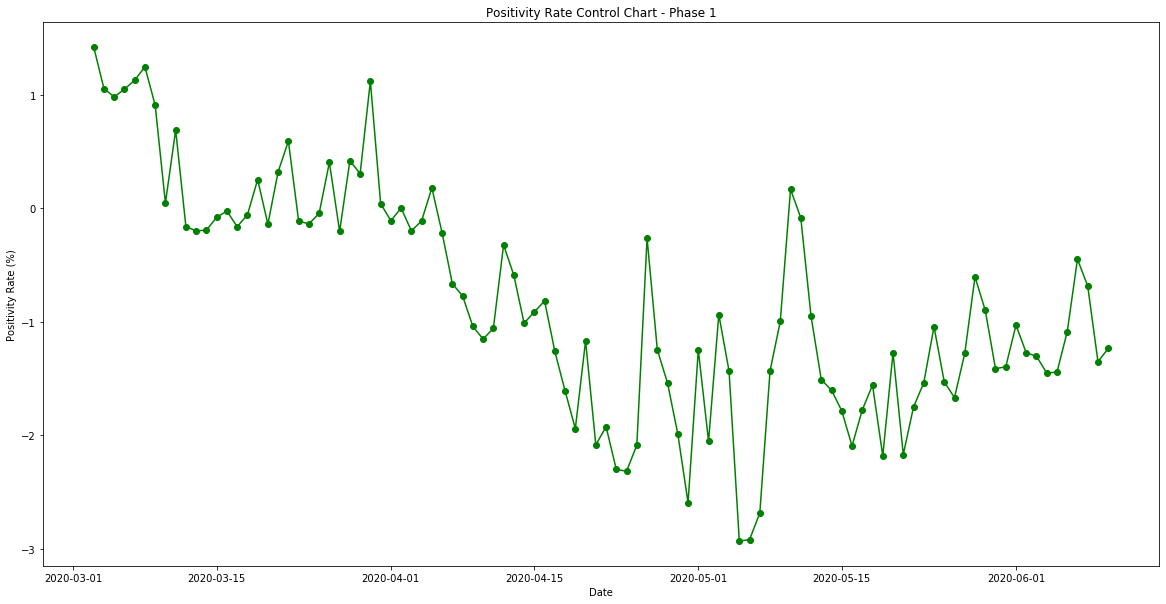

In [61]:
# X bar control chart 그리기

# Phase 1 control chart

plt.figure(figsize=(20,10))
plt.plot("posRate", data = phase1data, color = "green", marker = "o")
plt.title("Positivity Rate Control Chart - Phase 1")
plt.xlabel("Date")
plt.ylabel("Positivity Rate (%)")
plt.savefig("Shewhart xbar phase1.png")
plt.show()


In [36]:
# Revise control limits

while len(phase1data) > len(phase1data[(phase1data["posRate"]<=UCL0) & (phase1data["posRate"]>=LCL0)]) :
    phase1data = phase1data[(phase1data["posRate"]<=UCL0) & (phase1data["posRate"]>=LCL0)]
    [UCL0, CL0, LCL0] = find_cl(phase1data)

print(phase1data)
print(len(phase1data))
print(UCL0, CL0, LCL0)

# outlier 계속 제거 후 100개 중 60개 샘플만이 생존, 최종 control limit은
# 0.5591160243958968 0.25724851910617547 0

NameError: name 'phase1data' is not defined

###### Revised control limits에 따른 전체 기간의 Shewhart Control Chart

plt.figure(figsize=(20,10))
plt.plot("posRate", data = mrdata, color = "green", marker = "o")
plt.title("Positivity Rate")
plt.xlabel("Date")
plt.ylabel("log Positivity Rate (%)")
plt.vlines(sDD, ymin = -3.5, ymax = 3.5, linestyles = "dotted", color = "red")
plt.savefig("Shewhart xbar.png")
plt.show()

# 초기 100일을 phase1로 잡고 이상치를 모두 제거해서 control limit을 구하면 통제범위가 너무 좁다.
# 

                  MR   posRate
date                          
2020-04-22  0.159269 -1.925575
2020-04-23  0.376260 -2.301835
2020-04-24  0.015310 -2.317145
2020-04-25  0.229612 -2.087534
2020-04-26  1.824401 -0.263133
2020-04-27  0.983612 -1.246745
2020-04-28  0.295637 -1.542382
2020-04-29  0.446861 -1.989243
2020-04-30  0.605452 -2.594695
2020-05-01  1.346067 -1.248627
2020-05-02  0.805924 -2.054551
2020-05-03  1.117252 -0.937299
2020-05-04  0.497785 -1.435085
2020-05-05  1.497708 -2.932792
2020-05-06  0.013132 -2.919661


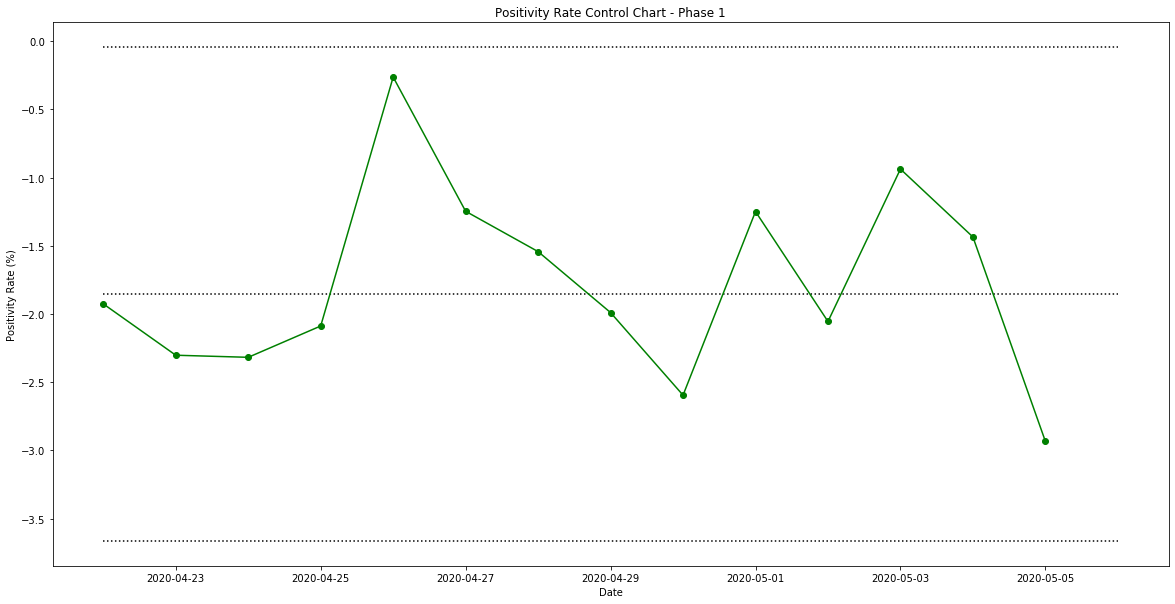

15
-0.042044232442106866 -1.8530868252838368 -3.664129418125567


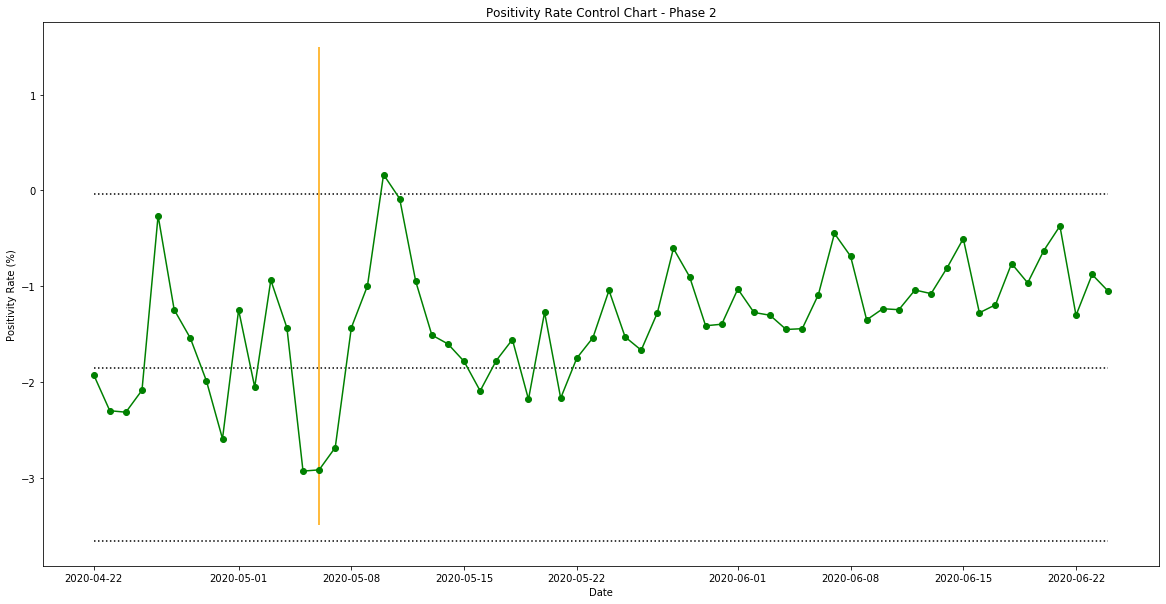

(0.981899619102478, 0.4693058431148529)


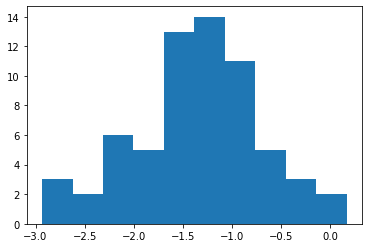

In [62]:
# 생활 속 거리두기 전환에 따른 양성률 통제 양상

# Phase 1 = 생활 속 거리두기(2020-05-06) 직전 2주
day1index = mrdata.index.get_loc(day1)
day1endindex = mrdata.index.get_loc(day1end)
day2index = mrdata.index.get_loc(day2)
day2endindex = mrdata.index.get_loc(day2end)
df1 = mrdata[day1index-14:day1index+1]
print(df1)
get_bar(df1, day1)
find_cl(df1, day1)

# Plot phase 1

plt.figure(figsize=(20,10))
plt.plot("posRate", data = df1[:14], color = "green", marker = "o")
plt.title("Positivity Rate Control Chart - Phase 1")
plt.xlabel("Date")
plt.ylabel("Positivity Rate (%)")
plt.hlines(find_cl(df1, day1), xmin = idx[50], xmax = idx[64], linestyles = "dotted")
plt.savefig("Shewhart xbar log 0506 phase1.png")
plt.show()

# Revise control limits
[UCL0, CL0, LCL0] = find_cl(df1, day1)
while len(df1) > len(df1[(df1["posRate"]<=UCL0) & (df1["posRate"]>=LCL0)]) :
    df1 = df1[(df1["posRate"]<=UCL0) & (df1["posRate"]>=LCL0)]
    [UCL0, CL0, LCL0] = find_cl(df1, day1)

print(len(df1)) # 4월 26일 제외(outlying)
print(UCL0, CL0, LCL0)

# Phase 2 = 생활 속 거리두기 ~ 사회적 거리두기 전환(2020-06-24) 전 기간
df2 = mrdata[day1index-14:day1endindex+1]
plt.figure(figsize=(20,10))
plt.plot("posRate", data = df2, color = "green", marker = "o")
plt.title("Positivity Rate Control Chart - Phase 2")
plt.xlabel("Date")
plt.ylabel("Positivity Rate (%)")
plt.hlines([UCL0, CL0, LCL0], xmin = idx[50], xmax = idx[113], linestyles = "dotted")
plt.vlines(day1, ymin = -3.5, ymax = 1.5, color = "orange")
plt.savefig("Shewhart xbar log 0506 phase2.png")
plt.show()

print(stats.shapiro(df2["posRate"]))
plt.hist(df2["posRate"])
plt.show()

                  MR   posRate
date                          
2020-08-16  0.876587  1.519682
2020-08-17  0.283732  1.235951
2020-08-18  0.123551  1.359502
2020-08-19  0.471347  0.888155
2020-08-20  0.238692  0.649463
2020-08-21  0.004106  0.645357
2020-08-22  0.006776  0.652132
2020-08-23  0.702039  1.354171
2020-08-24  0.623096  0.731075
2020-08-25  0.345833  0.385242
2020-08-26  0.024796  0.410038
2020-08-27  0.340172  0.750210
2020-08-28  0.105365  0.644845
2020-08-29  0.075421  0.569424
2020-08-30  0.442796  1.012220


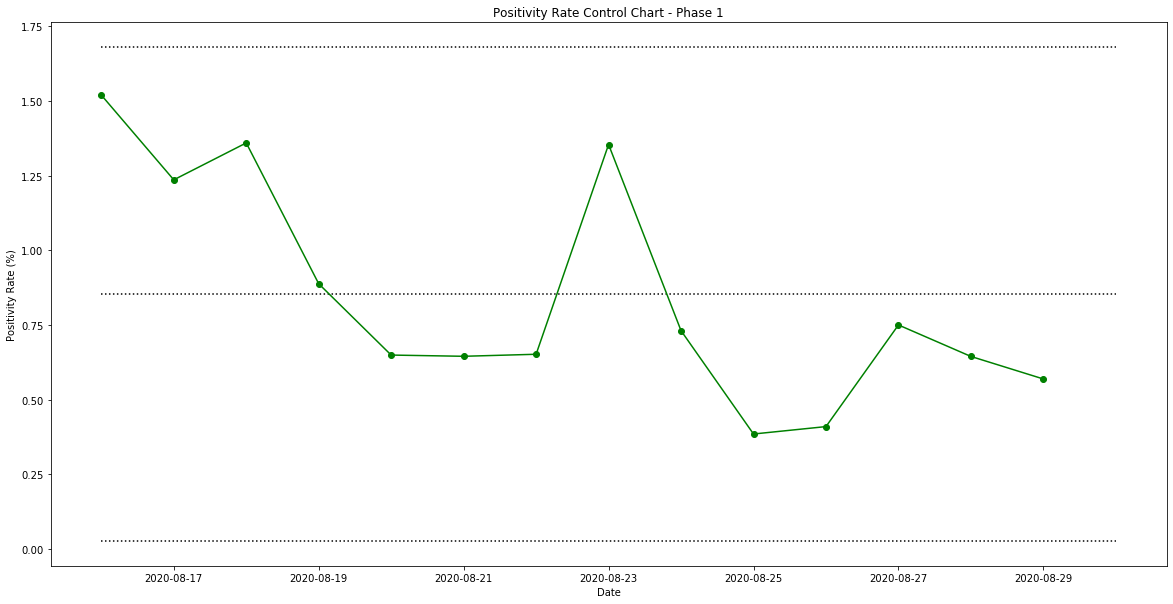

15
1.6808358413123567 0.8538311443738207 0.026826447435284728


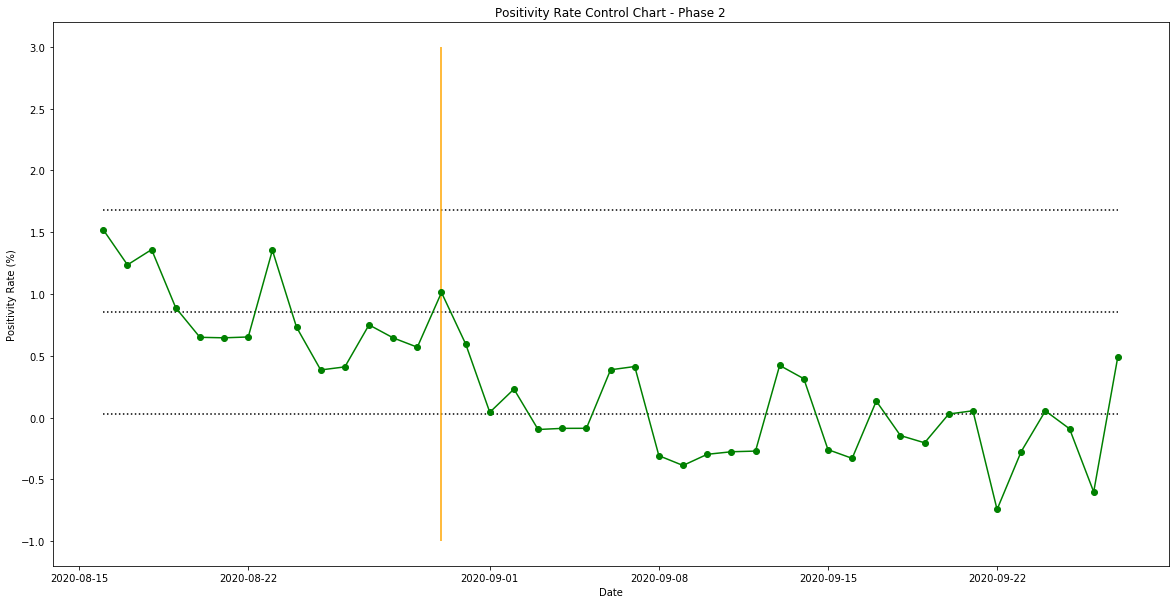

(0.962410032749176, 0.16976885497570038)


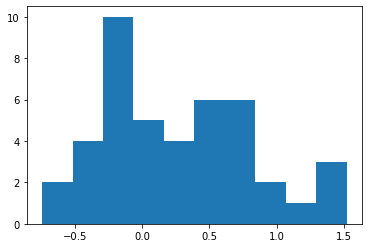

In [56]:
# 수도권 사회적 거리두기 2단계 정책 시행에 따른 양성률 통제

# Phase 1 = 수도권 2단계(2020-08-30) 직전 2주
day1index = mrdata.index.get_loc(day1)
day1endindex = mrdata.index.get_loc(day1end)
day2index = mrdata.index.get_loc(day2)
day2endindex = mrdata.index.get_loc(day2end)
df3 = mrdata[day2index-14:day2index+1]
print(df3)
get_bar(df3, day2)
find_cl(df3, day2)

# Plot phase 1

plt.figure(figsize=(20,10))
plt.plot("posRate", data = df3[:14], color = "green", marker = "o")
plt.title("Positivity Rate Control Chart - Phase 1")
plt.xlabel("Date")
plt.ylabel("Positivity Rate (%)")
plt.hlines(find_cl(df3, day2), xmin = idx[166], xmax = idx[180], linestyles = "dotted")
plt.savefig("Shewhart xbar log 0830 phase1.png")
plt.show()

# Revise control limits
[UCL0, CL0, LCL0] = find_cl(df3, day2)
while len(df3) > len(df3[(df3["posRate"]<=UCL0) & (df3["posRate"]>=LCL0)]) :
    df3 = df3[(df3["posRate"]<=UCL0) & (df3["posRate"]>=LCL0)]
    [UCL0, CL0, LCL0] = find_cl(df3, day2)

print(len(df3)) 
print(UCL0, CL0, LCL0)

# Phase 2 = 생활 속 거리두기 ~ 사회적 거리두기 전환(2020-06-24) 전 기간
df4 = mrdata[day2index-14:day2endindex+1]
plt.figure(figsize=(20,10))
plt.plot("posRate", data = df4, color = "green", marker = "o")
plt.title("Positivity Rate Control Chart - Phase 2")
plt.xlabel("Date")
plt.ylabel("Positivity Rate (%)")
plt.hlines([UCL0, CL0, LCL0], xmin = idx[166], xmax = idx[208], linestyles = "dotted")
plt.vlines(day2, ymin = -1, ymax = 3, color = "orange")
plt.savefig("Shewhart xbar log 0830 phase2.png")
plt.show()

print(stats.shapiro(df4["posRate"]))
plt.hist(df4["posRate"])
plt.show()

In [21]:
# Build a CUSUM Chart
h = 5
k = 1/2
n = len(recentdata["posRate"])
mu = np.mean(recentdata["posRate"])
sigma = np.std(recentdata["posRate"])
std_data = (recentdata["posRate"] - mu) / sigma
# Needs to be reversed, because the original data has recent observations first
std_data = list(std_data)
std_data.reverse()
date = list(date)
date.reverse()

cplus = []
cminus = []
cplus.append(max(0, std_data[0] + k))
cminus.append(max(0, -std_data[0] - k))

for i in range(n-1) :
    cplus.append(max(cplus[i]+std_data[i+1]-k, 0))
    cminus.append(max(cminus[i]-k-std_data[i+1], 0))
    
cusumData = pd.DataFrame({"date": date, "Cplus" : cplus, "Cminus" : cminus})
print(cusumData)
cusumData.set_index("date", inplace = True)

          date      Cplus  Cminus
0   2020-03-02   0.000000     0.0
1   2020-03-03   1.439211     0.0
2   2020-03-04   2.472695     0.0
3   2020-03-05   3.425081     0.0
4   2020-03-06   4.451833     0.0
..         ...        ...     ...
277 2020-12-04  18.011476     0.0
278 2020-12-05  19.017961     0.0
279 2020-12-06  20.640742     0.0
280 2020-12-07  22.129555     0.0
281 2020-12-08  24.125197     0.0

[282 rows x 3 columns]


             posRate
date                
2020-04-22 -0.100780
2020-04-23 -0.623891
2020-04-24 -0.645177
2020-04-25 -0.325950
2020-04-26  2.210501
2020-04-27  0.842993
2020-04-28  0.431971
2020-04-29 -0.189297
2020-04-30 -1.031052
2020-05-01  0.840376
2020-05-02 -0.280094
2020-05-03  1.273213
2020-05-04  0.581146
2020-05-05 -1.501107
2020-05-06 -1.482850
             posRate     Cplus    Cminus
date                                    
2020-04-22 -0.100780  0.399220  0.000000
2020-04-23 -0.623891  0.000000  0.123891
2020-04-24 -0.645177  0.000000  0.269068
2020-04-25 -0.325950  0.000000  0.095018
2020-04-26  2.210501  1.710501  0.000000
2020-04-27  0.842993  2.053494  0.000000
2020-04-28  0.431971  1.985465  0.000000
2020-04-29 -0.189297  1.296168  0.000000
2020-04-30 -1.031052  0.000000  0.531052
2020-05-01  0.840376  0.340376  0.000000
2020-05-02 -0.280094  0.000000  0.000000
2020-05-03  1.273213  0.773213  0.000000
2020-05-04  0.581146  0.854359  0.000000
2020-05-05 -1.501107  0.0000

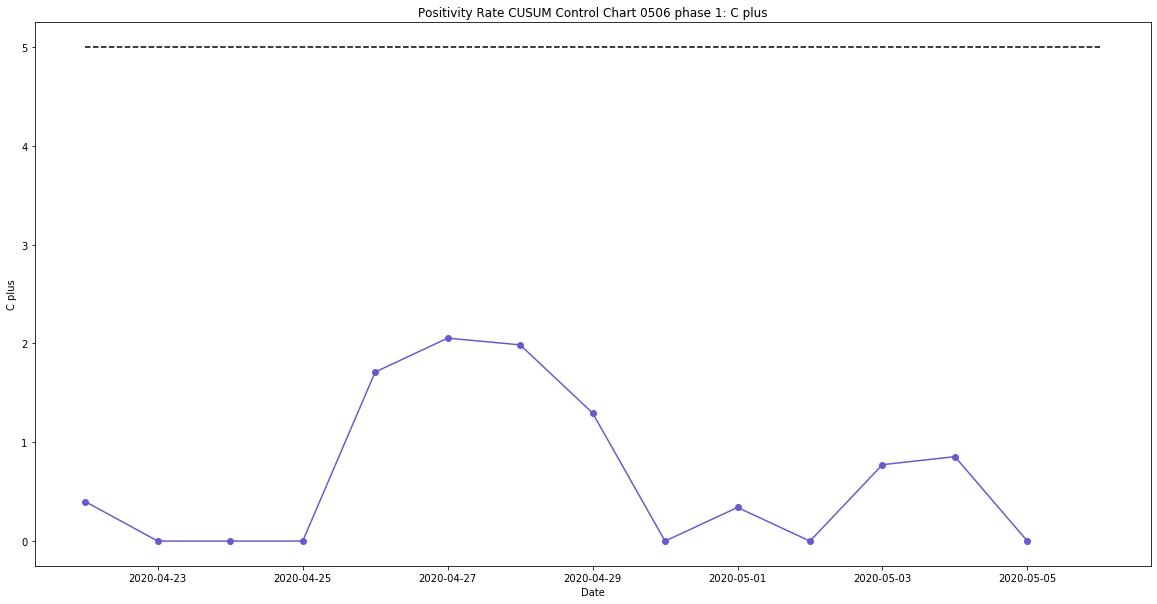

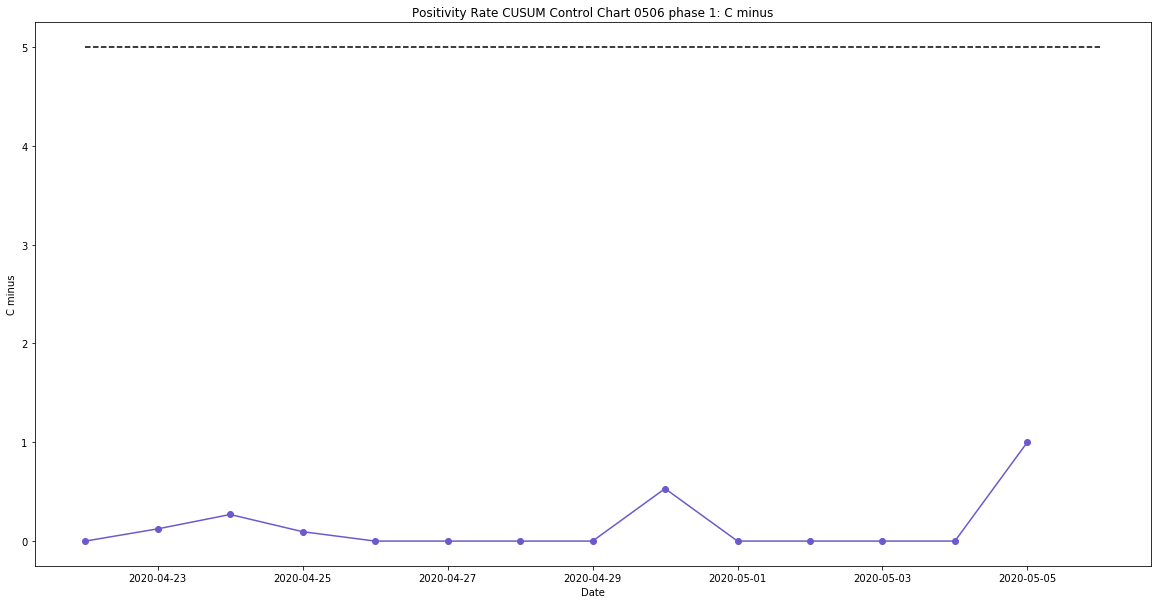

             posRate
date                
2020-04-22 -0.100780
2020-04-23 -0.623891
2020-04-24 -0.645177
2020-04-25 -0.325950
2020-04-26  2.210501
...              ...
2020-06-20  1.702881
2020-06-21  2.059552
2020-06-22  0.761574
2020-06-23  1.355277
2020-06-24  1.112337

[64 rows x 1 columns]
             posRate      Cplus    Cminus
date                                     
2020-04-22 -0.100780   0.399220  0.000000
2020-04-23 -0.623891   0.000000  0.123891
2020-04-24 -0.645177   0.000000  0.269068
2020-04-25 -0.325950   0.000000  0.095018
2020-04-26  2.210501   1.710501  0.000000
...              ...        ...       ...
2020-06-20  1.702881  17.365961  0.000000
2020-06-21  2.059552  18.925513  0.000000
2020-06-22  0.761574  19.187086  0.000000
2020-06-23  1.355277  20.042363  0.000000
2020-06-24  1.112337  20.654700  0.000000

[64 rows x 3 columns]


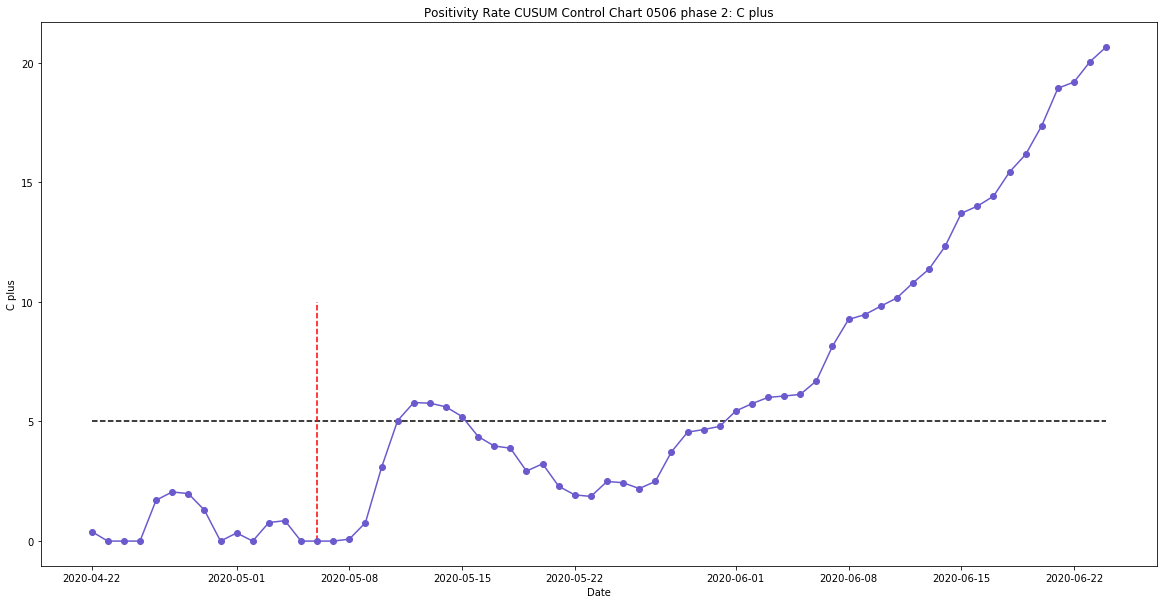

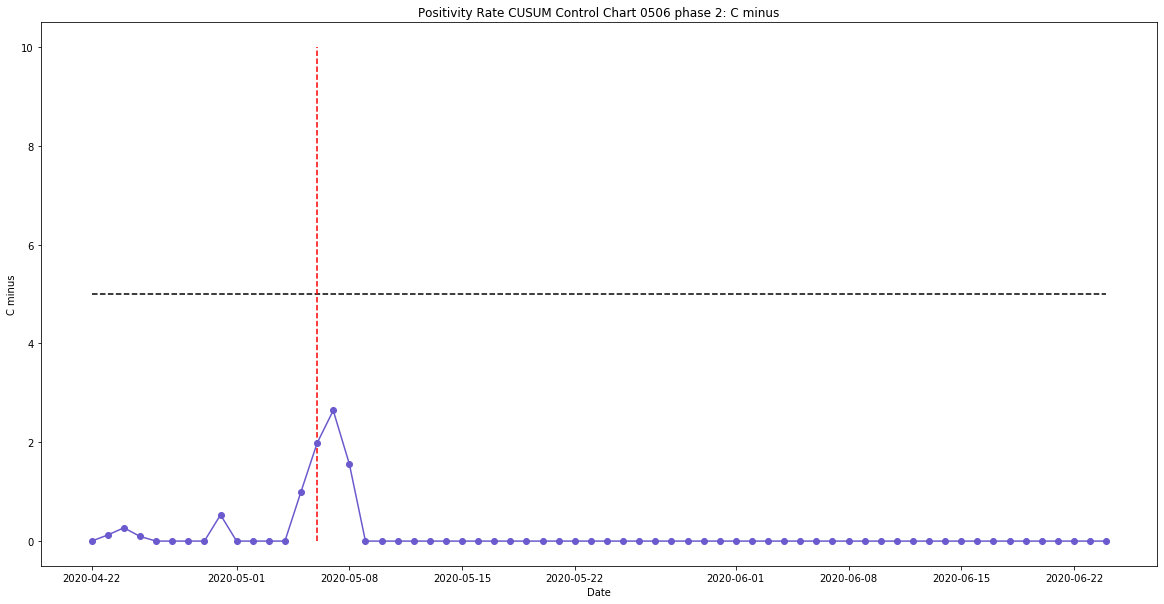

In [63]:
# 0506 CUSUM Chart
h = 5
k = 1/2
n = len(df1["posRate"])
mu = np.mean(df1["posRate"])
sigma = np.std(df1["posRate"])
std_data = pd.DataFrame((df1["posRate"] - mu) / sigma)
print(std_data)

cplus = []
cminus = []
cplus.append(max(0, std_data["posRate"][0] + k))
cminus.append(max(0, -std_data["posRate"][0] - k))

for i in range(n-1) :
    cplus.append(max(cplus[i]+std_data["posRate"][i+1]-k, 0))
    cminus.append(max(cminus[i]-k-std_data["posRate"][i+1], 0))
    
std_data["Cplus"] = cplus
std_data["Cminus"] = cminus

cusumData = std_data
print(cusumData)

# Plot phase 1 cusum chart
plt.figure(figsize=(20,10))
plt.plot("Cplus", data = cusumData[0:14], color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart 0506 phase 1: C plus")
plt.xlabel("Date")
plt.ylabel("C plus")
plt.hlines(5, xmin = idx[50], xmax = idx[64], linestyles = "dashed")
plt.savefig("CUSUM cplus 0506 phase 1.png")
plt.show() # no OC observations

plt.figure(figsize=(20,10))
plt.plot("Cminus", data = cusumData[0:14], color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart 0506 phase 1: C minus")
plt.xlabel("Date")
plt.ylabel("C minus")
plt.hlines(5, xmin = idx[50], xmax = idx[64], linestyles = "dashed")
plt.savefig("CUSUM cminus 0506 phase 1.png")
plt.show() # no OC observations

# phase 2 cusum chart
n = len(df2["posRate"])
std_data = pd.DataFrame((df2["posRate"] - mu) / sigma)
print(std_data)

cplus = []
cminus = []
cplus.append(max(0, std_data["posRate"][0] + k))
cminus.append(max(0, -std_data["posRate"][0] - k))

for i in range(n-1) :
    cplus.append(max(cplus[i]+std_data["posRate"][i+1]-k, 0))
    cminus.append(max(cminus[i]-k-std_data["posRate"][i+1], 0))
    
std_data["Cplus"] = cplus
std_data["Cminus"] = cminus

cusumData = std_data
print(cusumData)

plt.figure(figsize=(20,10))
plt.plot("Cplus", data = cusumData, color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart 0506 phase 2: C plus")
plt.xlabel("Date")
plt.ylabel("C plus")
plt.hlines(5, xmin = idx[50], xmax = idx[113], linestyles = "dashed")
plt.vlines(idx[64], ymin = 0, ymax = 10, linestyles = "dashed", color = "red")
plt.savefig("CUSUM cplus 0506 phase 2.png")
plt.show() # we see a surge

plt.figure(figsize=(20,10))
plt.plot("Cminus", data = cusumData, color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart 0506 phase 2: C minus")
plt.xlabel("Date")
plt.ylabel("C minus")
plt.hlines(5, xmin = idx[50], xmax = idx[113], linestyles = "dashed")
plt.vlines(idx[64], ymin = 0, ymax = 10, linestyles = "dashed", color = "red")
plt.savefig("CUSUM cminus 0506 phase 2.png")
plt.show() # no OC observations

             posRate
date                
2020-08-16  1.914457
2020-08-17  1.098671
2020-08-18  1.453906
2020-08-19  0.098688
2020-08-20 -0.587601
2020-08-21 -0.599406
2020-08-22 -0.579925
2020-08-23  1.438579
2020-08-24 -0.352947
2020-08-25 -1.347288
2020-08-26 -1.275995
2020-08-27 -0.297933
2020-08-28 -0.600878
2020-08-29 -0.817729
2020-08-30  0.455400
             posRate     Cplus    Cminus
date                                    
2020-08-16  1.914457  2.414457  0.000000
2020-08-17  1.098671  3.013129  0.000000
2020-08-18  1.453906  3.967035  0.000000
2020-08-19  0.098688  3.565723  0.000000
2020-08-20 -0.587601  2.478122  0.087601
2020-08-21 -0.599406  1.378716  0.187007
2020-08-22 -0.579925  0.298792  0.266931
2020-08-23  1.438579  1.237370  0.000000
2020-08-24 -0.352947  0.384423  0.000000
2020-08-25 -1.347288  0.000000  0.847288
2020-08-26 -1.275995  0.000000  1.623283
2020-08-27 -0.297933  0.000000  1.421216
2020-08-28 -0.600878  0.000000  1.522094
2020-08-29 -0.817729  0.0000

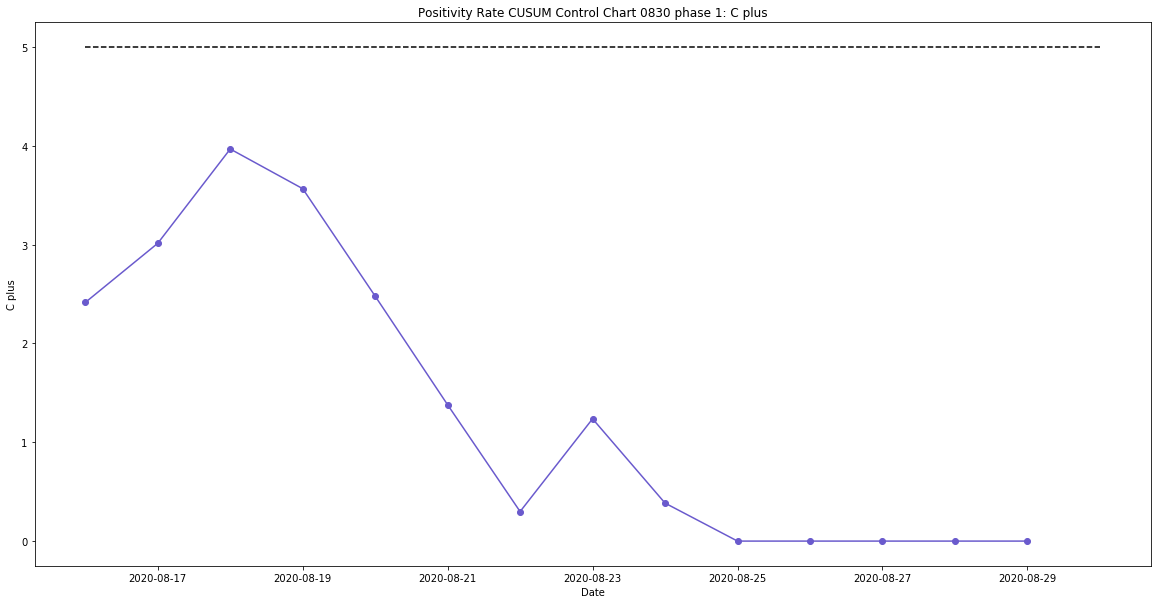

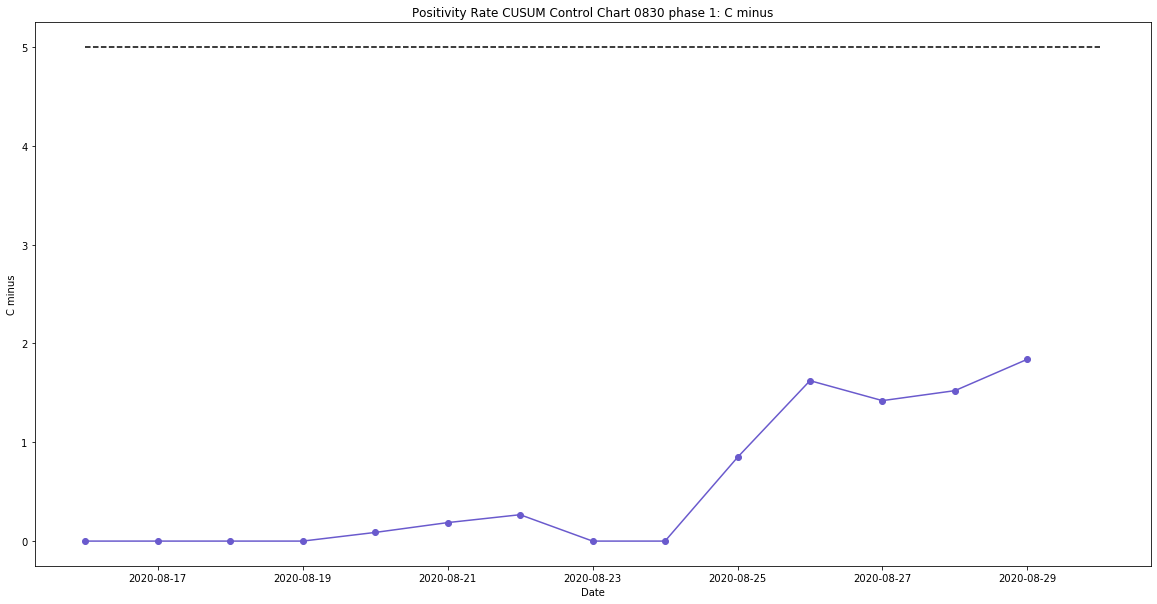

             posRate
date                
2020-08-16  1.914457
2020-08-17  1.098671
2020-08-18  1.453906
2020-08-19  0.098688
2020-08-20 -0.587601
2020-08-21 -0.599406
2020-08-22 -0.579925
2020-08-23  1.438579
2020-08-24 -0.352947
2020-08-25 -1.347288
2020-08-26 -1.275995
2020-08-27 -0.297933
2020-08-28 -0.600878
2020-08-29 -0.817729
2020-08-30  0.455400
2020-08-31 -0.741090
2020-09-01 -2.332974
2020-09-02 -1.793093
2020-09-03 -2.733126
2020-09-04 -2.706710
2020-09-05 -2.705227
2020-09-06 -1.343547
2020-09-07 -1.267559
2020-09-08 -3.342747
2020-09-09 -3.570283
2020-09-10 -3.310508
2020-09-11 -3.251081
2020-09-12 -3.235675
2020-09-13 -1.241464
2020-09-14 -1.551526
2020-09-15 -3.201349
2020-09-16 -3.404497
2020-09-17 -2.072404
2020-09-18 -2.874190
2020-09-19 -3.042698
2020-09-20 -2.373139
2020-09-21 -2.297064
2020-09-22 -4.594212
2020-09-23 -3.245651
2020-09-24 -2.300186
2020-09-25 -2.716105
2020-09-26 -4.185506
2020-09-27 -1.037207
             posRate     Cplus     Cminus
date         

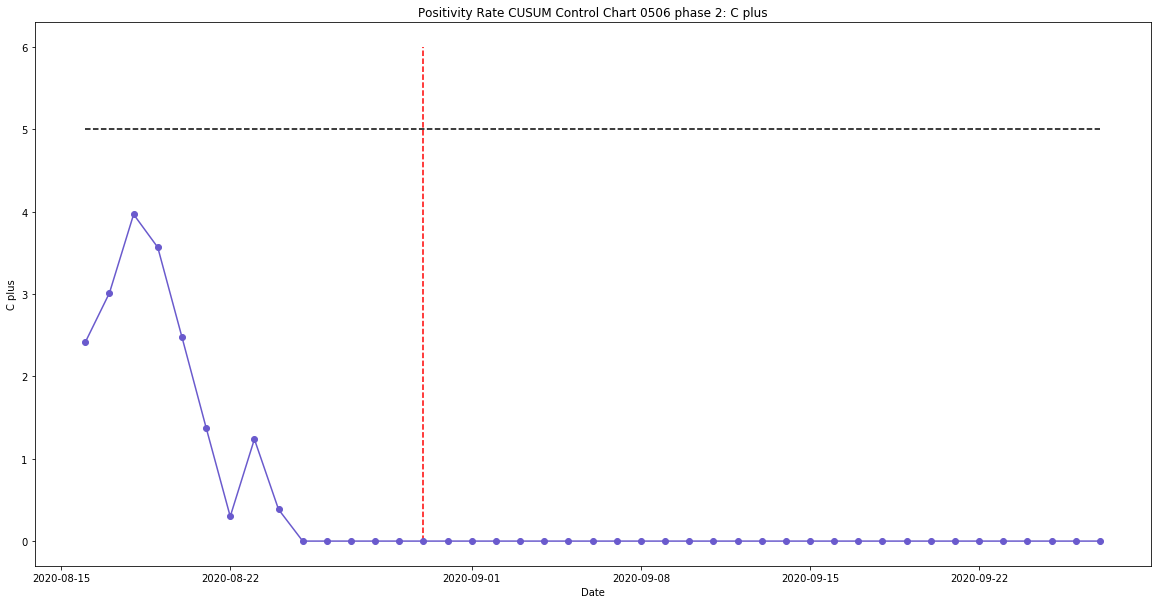

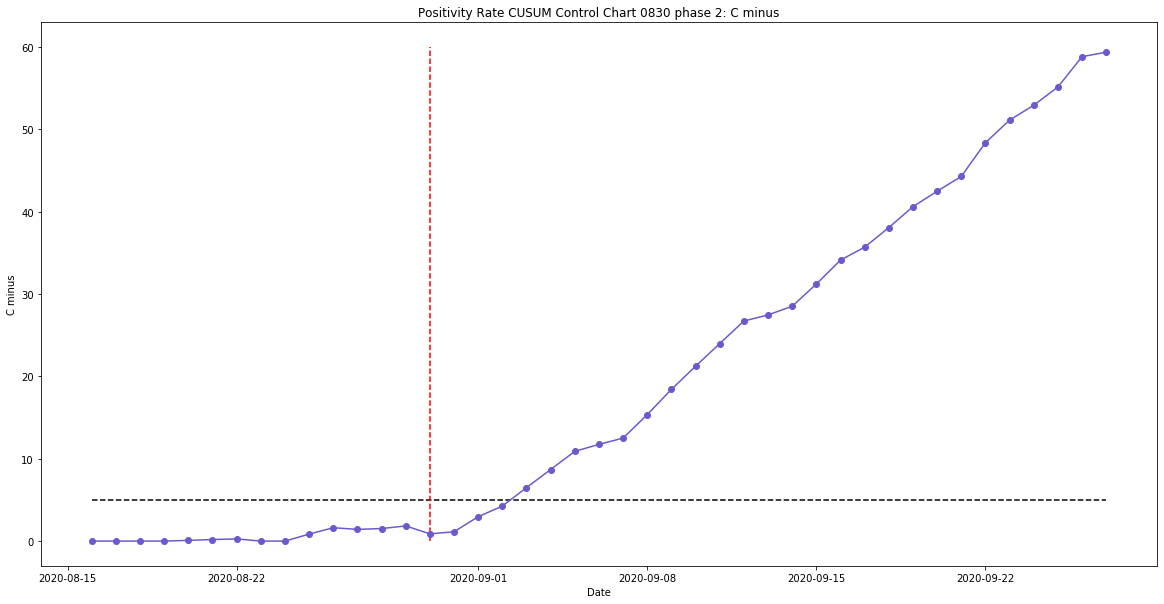

In [64]:
# 0830 CUSUM Chart
h = 5
k = 1/2
n = len(df3["posRate"])
mu = np.mean(df3["posRate"])
sigma = np.std(df3["posRate"])
std_data = pd.DataFrame((df3["posRate"] - mu) / sigma)
print(std_data)

cplus = []
cminus = []
cplus.append(max(0, std_data["posRate"][0] + k))
cminus.append(max(0, -std_data["posRate"][0] - k))

for i in range(n-1) :
    cplus.append(max(cplus[i]+std_data["posRate"][i+1]-k, 0))
    cminus.append(max(cminus[i]-k-std_data["posRate"][i+1], 0))
    
std_data["Cplus"] = cplus
std_data["Cminus"] = cminus

cusumData = std_data
print(cusumData)

# Plot phase 1 cusum chart
plt.figure(figsize=(20,10))
plt.plot("Cplus", data = cusumData[0:14], color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart 0830 phase 1: C plus")
plt.xlabel("Date")
plt.ylabel("C plus")
plt.hlines(5, xmin = idx[166], xmax = idx[180], linestyles = "dashed")
plt.savefig("CUSUM cplus 0830 phase 1.png")
plt.show() # no OC observations

plt.figure(figsize=(20,10))
plt.plot("Cminus", data = cusumData[0:14], color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart 0830 phase 1: C minus")
plt.xlabel("Date")
plt.ylabel("C minus")
plt.hlines(5, xmin = idx[166], xmax = idx[180], linestyles = "dashed")
plt.savefig("CUSUM cminus 0830 phase 1.png")
plt.show() # no OC observations

# phase 2 cusum chart
n = len(df4["posRate"])
std_data = pd.DataFrame((df4["posRate"] - mu) / sigma)
print(std_data)

cplus = []
cminus = []
cplus.append(max(0, std_data["posRate"][0] + k))
cminus.append(max(0, -std_data["posRate"][0] - k))

for i in range(n-1) :
    cplus.append(max(cplus[i]+std_data["posRate"][i+1]-k, 0))
    cminus.append(max(cminus[i]-k-std_data["posRate"][i+1], 0))
    
std_data["Cplus"] = cplus
std_data["Cminus"] = cminus

cusumData = std_data
print(cusumData)

plt.figure(figsize=(20,10))
plt.plot("Cplus", data = cusumData, color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart 0506 phase 2: C plus")
plt.xlabel("Date")
plt.ylabel("C plus")
plt.hlines(5, xmin = idx[166], xmax = idx[208], linestyles = "dashed")
plt.vlines(idx[180], ymin = 0, ymax = 6, linestyles = "dashed", color = "red")
plt.savefig("CUSUM cplus 0830 phase 2.png")
plt.show()

plt.figure(figsize=(20,10))
plt.plot("Cminus", data = cusumData, color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart 0830 phase 2: C minus")
plt.xlabel("Date")
plt.ylabel("C minus")
plt.hlines(5, xmin = idx[166], xmax = idx[208], linestyles = "dashed")
plt.vlines(idx[180], ymin = 0, ymax = 60, linestyles = "dashed", color = "red")
plt.savefig("CUSUM cminus 0830 phase 2.png")
plt.show() # no OC observations

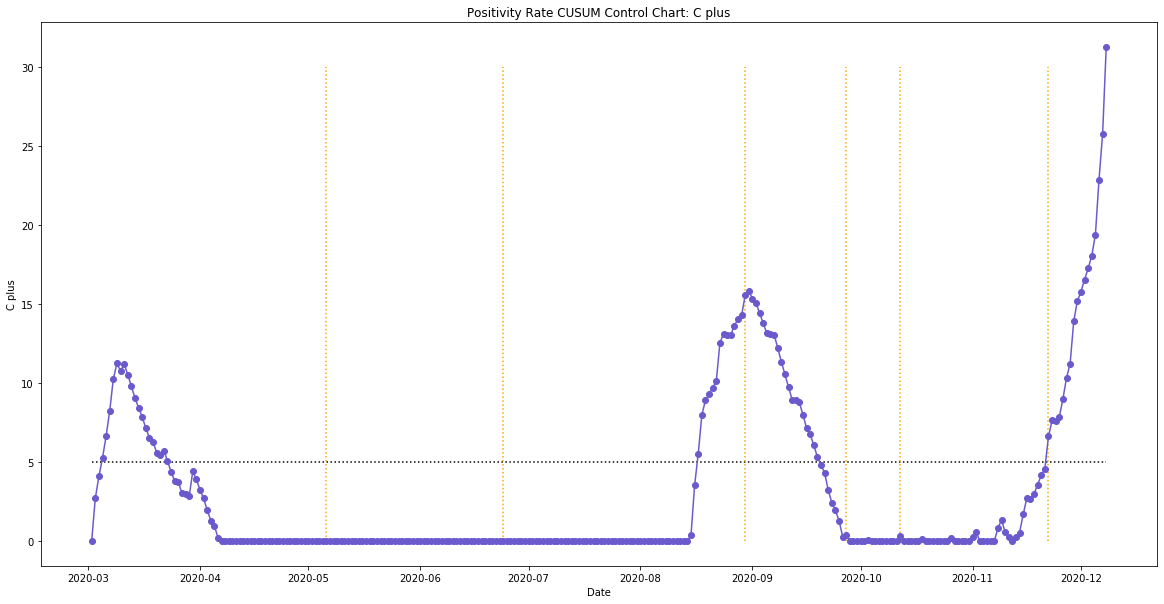

In [70]:
# C plus CUSUM Chart
plt.figure(figsize=(20,10))
idx = list(cusumData.index.values)
plt.plot("Cplus", data = cusumData, color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart: C plus")
plt.xlabel("Date")
plt.ylabel("C plus")
plt.hlines(5, xmin = idx[0], xmax = idx[-1], linestyles = "dotted")
plt.vlines(sDD, ymin = 0, ymax = 30, linestyles = "dotted", color = "orange")
plt.savefig("CUSUM cplus.png")
plt.show()

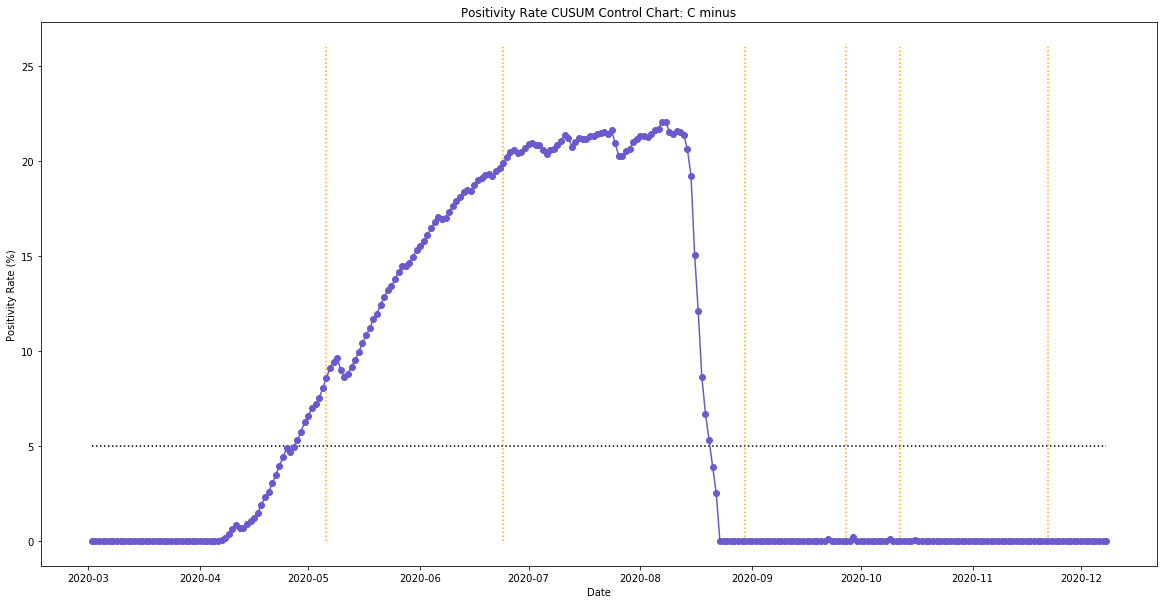

In [16]:
# Plot Cminus CUSUM chart
plt.figure(figsize=(20,10))
idx = list(cusumData.index.values)
plt.plot("Cminus", data = cusumData, color = "slateblue", marker = "o")
plt.title("Positivity Rate CUSUM Control Chart: C minus")
plt.xlabel("Date")
plt.ylabel("Positivity Rate (%)")
plt.hlines(5, xmin = idx[0], xmax = idx[-1], linestyles = "dotted")
plt.vlines(sDD, ymin = 0, ymax = 26, linestyles = "dotted", color = "orange")
plt.savefig("CUSUM cminus.png")
plt.show()

(0.8000053763389587, 2.7132012128300714e-18)


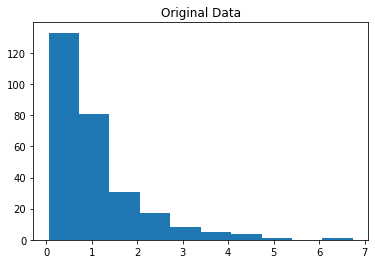

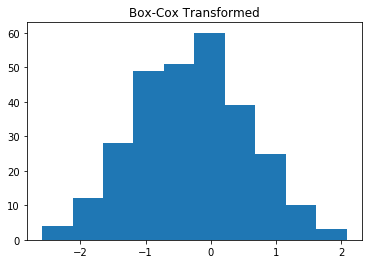

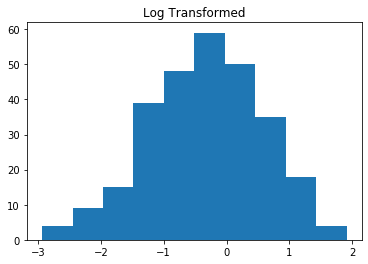

(0.9968136548995972, 0.8512771725654602)
(0.9941287636756897, 0.348929762840271)


In [53]:
# Check normality assumption
print(stats.shapiro(recentdata["posRate"].dropna()))
plt.hist(recentdata["posRate"].dropna())
plt.title("Original Data")
plt.show()

# Not even close to normality!! TㅁT
# Shapiro Wilk test for exponentiality says quasi-yes (done in R) -- [p-value 0.968]

# apply transformations?
reverse = list(recentdata["posRate"])
reverse.reverse()
reverse = pd.Series(reverse)
boxcoxTransformed = stats.boxcox(reverse.dropna())[0]
logTransformed = [math.log(x) for x in reverse.dropna()]
plt.hist(boxcoxTransformed)
plt.title("Box-Cox Transformed")
plt.savefig("boxcox.png")
plt.show()

plt.hist(logTransformed)
plt.title("Log Transformed")
plt.savefig("logtrans.png")
plt.show()

print(stats.shapiro(boxcoxTransformed))
print(stats.shapiro(logTransformed))

# Box-Cox 와 log 모두 괜찮은 변환이다. shapiro-wilk test 통과
# 나중에 결과 해석을 용이하게 하려면 로그변환이 그나마 좋을 것 같다. box-cox 변환은 함수 이해하는 것도 어려우니까ㅋㅋ

# 걱정되는 점은, 결국 양성판정률을 다루는 거니까 0~3 사이의 값들인데, 로그는 1보다 작은 값들은 진짜 조금만 바뀌어도
# 값이 급변해서 컨트롤 차트 그리기에는 적합하지 않을 것 같다. lower control limit 쪽이 이상해질 것 같은데...

0.9556743916424041


c:\users\jooye\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\jooye\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


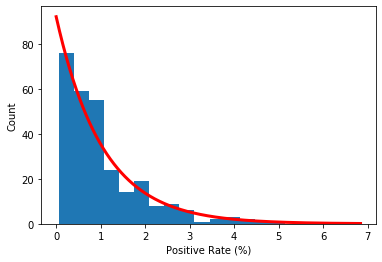

In [18]:
# Fit an exponential distribution to the original data and find the ARL

# MLE says lambda_hat = 1/mean

mean = np.mean(reverse.dropna())
lambda_hat = 1.0/mean
print(lambda_hat)
pRmax = max(reverse.dropna())

linspace = np.linspace(0, pRmax, 1000)

est_exp = stats.expon.pdf(linspace, scale=1. / lambda_hat)

nbins = 20
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(reverse, nbins)
ax.plot(linspace, est_exp * len(reverse) * pRmax / nbins, color = "red", lw=3)
ax.set_xlabel("Positive Rate (%)")
ax.set_ylabel("Count")
plt.savefig("expon fit.png")
plt.show()

# Fits quite well

In [19]:
# Build EWMA Chart

def ewmaStat(x, L = 3, lda = 0.2) :
    Z = [0]
    n = len(x)
    for i in range(n-1):
        Z.append(lda*x[i+1] + (1-lda)*Z[i])
    return Z

Zlog = ewmaStat(logTransformed)

# Control Limits (for the first 100 days)
mu0 = np.mean(logTransformed[0:100])
sigma0 = np.std(logTransformed[0:100])
lda = 0.2
L = 3
UCL = mu0 + L*sigma0*np.sqrt(lda/(2-lda))
LCL = mu0 - L*sigma0*np.sqrt(lda/(2-lda))


In [122]:
# 0506 EWMA Chart
logewma0506 = ewmaStat(df1["posRate"])

df1["ewma"] = logewma0506

mu0 = np.mean(df1["posRate"])
sigma0 = np.std(df1["posRate"])
lda = 0.2
L = 3
UCL = mu0 + L*sigma0*np.sqrt(lda/(2-lda))
LCL = mu0 - L*sigma0*np.sqrt(lda/(2-lda))

plt.figure(figsize=(20,10))
plt.plot("ewma", data = df1, color = "slateblue", marker = "o")
plt.title("Positivity Rate EWMA Control Chart 0506 Phase 1")
plt.xlabel("Date")
plt.ylabel("log Positivity Rate (%)")
plt.hlines([UCL, LCL], xmin = idx[0], xmax = idx[-1], linestyles = "dotted")
plt.vlines(sDD, ymin = -2, ymax = 1.2, linestyles = "dotted", color = "orange")
plt.savefig("log EWMA.png")
plt.show()

<ipython-input-122-0a61e0dfbf89>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["ewma"] = logewma0506


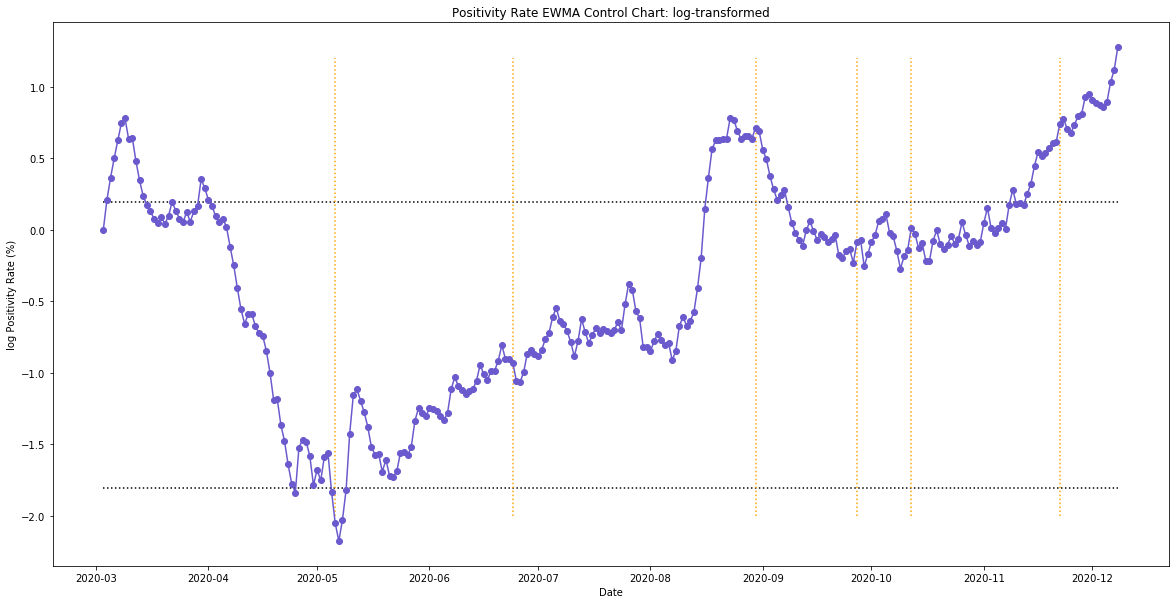

In [20]:
# Plot EWMA using log-transformed positive rate

logEWMAData = pd.DataFrame({"date": date[1:], "Z" : Zlog})
logEWMAData.set_index("date", inplace = True)

plt.figure(figsize=(20,10))
idx = list(logEWMAData.index.values)
plt.plot("Z", data = logEWMAData, color = "slateblue", marker = "o")
plt.title("Positivity Rate EWMA Control Chart: log-transformed")
plt.xlabel("Date")
plt.ylabel("log Positivity Rate (%)")
plt.hlines([UCL, LCL], xmin = idx[0], xmax = idx[-1], linestyles = "dotted")
plt.vlines(sDD, ymin = -2, ymax = 1.2, linestyles = "dotted", color = "orange")
plt.savefig("log EWMA.png")
plt.show()

1.556179486823245


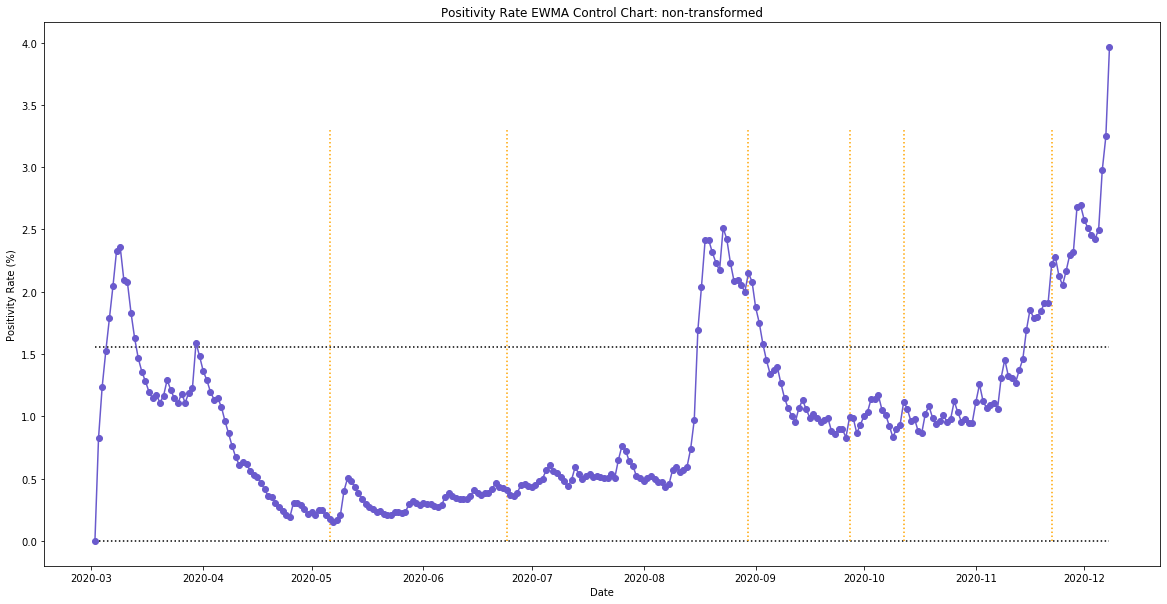

In [21]:
# Build EWMA Chart without transformation

ewma = ewmaStat(reverse)
ewmaData = pd.DataFrame({"date": date, "Z": ewma})
ewmaData.set_index("date", inplace = True)

# Control Limits
mu = np.mean(reverse[0:100])
sigma = np.std(reverse[0:100])
UCL = mu + L*sigma*np.sqrt(lda/(2-lda))
LCL = max(0, mu - L*sigma*np.sqrt(lda/(2-lda)))
print(UCL)
# Plot EWMA Chart
plt.figure(figsize=(20,10))
idx = list(ewmaData.index.values)
plt.plot("Z", data = ewmaData, color = "slateblue", marker = "o")
plt.title("Positivity Rate EWMA Control Chart: non-transformed")
plt.xlabel("Date")
plt.ylabel("Positivity Rate (%)")
plt.hlines([UCL, LCL], xmin = idx[0], xmax = idx[-1], linestyles = "dotted")
plt.vlines(sDD, ymin = 0, ymax = 3.3, linestyles = "dotted", color = "orange")
plt.savefig("EWMA.png")
plt.show()